In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import itertools
import time
import warnings
from collections import Counter
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')

# Transform image

In [ ]:
IMG_SIZE = (255, 255)
BATCH_SIZE = 32

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def normalize_image(img):
    img = tf.cast(img, tf.float32) / 255.0
    img = (img - IMAGENET_MEAN) / IMAGENET_STD
    return img

def random_rotate(image):
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    return tf.image.rot90(image, k)

def preprocess_train(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = random_rotate(image)
    image = normalize_image(image)
    return image, label

def preprocess_eval(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = normalize_image(image)
    return image, label

# Load Data

In [ ]:
from google.colab import files
files.upload()  # pilih kaggle.json dari komputermu


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fazarrizky","key":"e241929ae67c898bd5dcfeed8fb375e2"}'}

In [ ]:
os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d pkdarabi/diagnosis-of-diabetic-retinopathy
!unzip diagnosis-of-diabetic-retinopathy.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/Diagnosis of Diabetic Retinopathy/train/DR/62ecdc90dd42_png.rf.3bcda5e9f64ebe4c7c224193e39a7574.jpg  
  inflating: ./data/Diagnosis of Diabetic Retinopathy/train/DR/63363410389a_png.rf.89c01cd2c44c1a75b38f655931468332.jpg  
  inflating: ./data/Diagnosis of Diabetic Retinopathy/train/DR/6363b360aefb_png.rf.3f17e87b84463b33e30bb6639c134657.jpg  
  inflating: ./data/Diagnosis of Diabetic Retinopathy/train/DR/6377e23928f6_png.rf.fee7583c180ba521afe51c884afa5ec2.jpg  
  inflating: ./data/Diagnosis of Diabetic Retinopathy/train/DR/63c3c571b8ee_png.rf.16a469817e7755136cfc4d04e16a8aaa.jpg  
  inflating: ./data/Diagnosis of Diabetic Retinopathy/train/DR/64678182d8a8_png.rf.39a6c766321a8615d6d0aa254338054d.jpg  
  inflating: ./data/Diagnosis of Diabetic Retinopathy/train/DR/64bad93fde3f_png.rf.961aba9d5933a5c28a41730165ac7ea4.jpg  
  inflating: ./data/Diagnosis of Diabetic Retinopathy/train/DR/650fbed3fdca_png.rf.f44a18885af9

In [ ]:
data_dir = "./data/Diagnosis of Diabetic Retinopathy"

train_set = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
).map(preprocess_train).shuffle(1000).prefetch(tf.data.AUTOTUNE)

val_set = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
).map(preprocess_eval).prefetch(tf.data.AUTOTUNE)

test_set = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
).map(preprocess_eval).prefetch(tf.data.AUTOTUNE)


Found 2076 files belonging to 2 classes.
Found 531 files belonging to 2 classes.
Found 231 files belonging to 2 classes.


# Eda Data

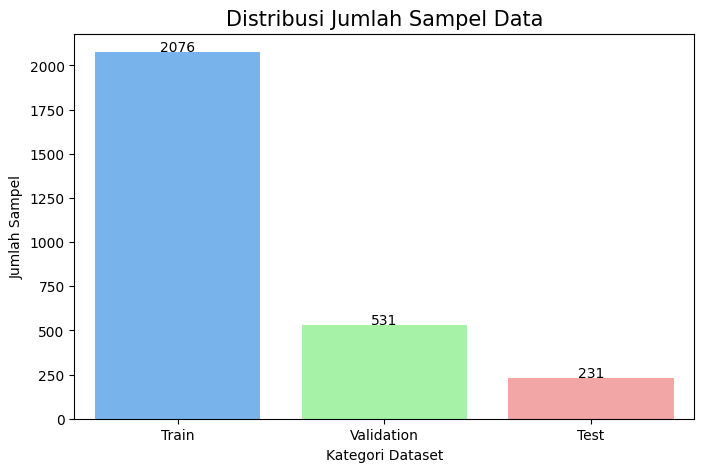

In [ ]:
def total_samples(dataset):
    total = 0
    for images, labels in dataset:
        total += images.shape[0]
    return total
categories = ['Train', 'Validation', 'Test']
colors = ['#66b3ff', '#99ff99', '#ff9999']
counts_samples = [total_samples(train_set), total_samples(val_set), total_samples(test_set)]

plt.figure(figsize=(8, 5))
sns.barplot(x=categories, y=counts_samples, palette=colors)
plt.title('Distribusi Jumlah Sampel Data', fontsize=15)
plt.xlabel('Kategori Dataset')
plt.ylabel('Jumlah Sampel')
for i, count in enumerate(counts_samples):
    plt.text(i, count + 5, str(count), ha='center')
plt.show()

Found 2076 files belonging to 2 classes.


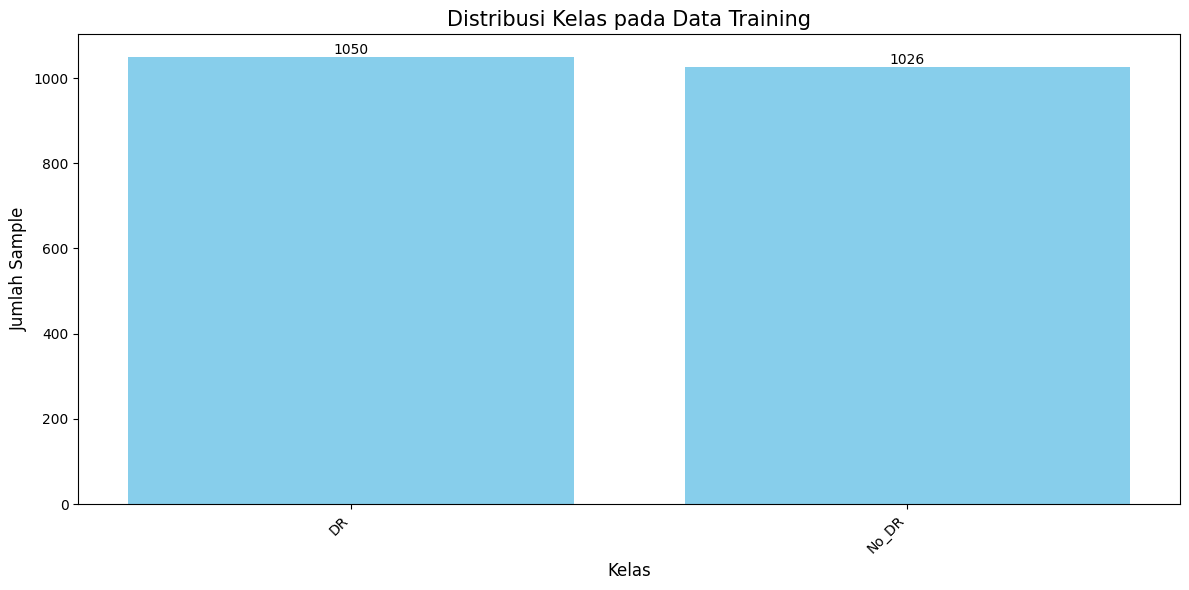

In [ ]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)
class_names = raw_train_ds.class_names

all_labels = []
for _, labels in raw_train_ds.unbatch():
    all_labels.append(int(labels.numpy()))

class_counts = Counter(all_labels)

class_names_sorted = [class_names[i] for i in sorted(class_counts.keys())]
counts = [class_counts[i] for i in sorted(class_counts.keys())]

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names_sorted, counts, color='skyblue')

plt.title('Distribusi Kelas pada Data Training', fontsize=15)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Sample', fontsize=12)
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

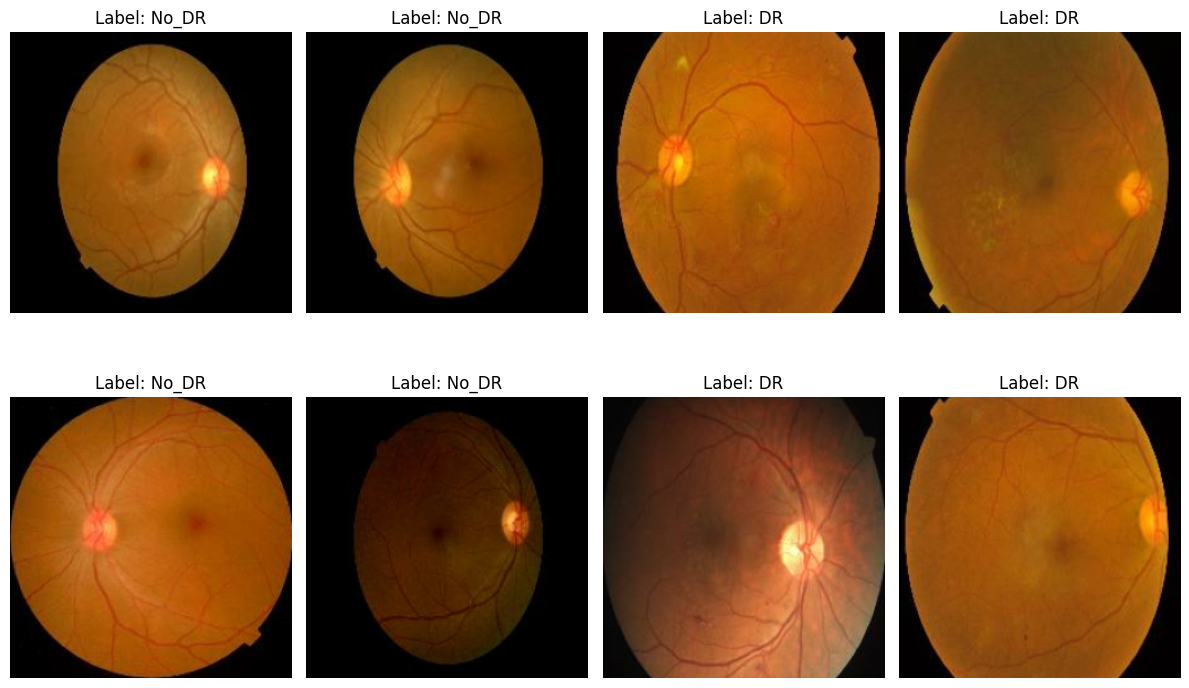

In [ ]:
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    return np.clip(img, 0, 1)

plt.figure(figsize=(12, 8))

for images, labels in train_set.take(1):
    images = images.numpy()
    labels = labels.numpy()

    for i in range(8):
        img = denormalize(images[i])
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')

plt.tight_layout()
plt.show()


# Build Model

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(255, 255, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 256)      │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,397,570 (35.85 MB)

 Trainable params: 2,360,066 (9.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

# Training

In [ ]:
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 84s 680ms/step - accuracy: 0.7155 - loss: 1.3132 - val_accuracy: 0.9228 - val_loss: 0.1968 - learning_rate: 0.0010
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.9087 - loss: 0.2169 - val_accuracy: 0.9492 - val_loss: 0.1266 - learning_rate: 0.0010
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9495 - loss: 0.1672 - val_accuracy: 0.9623 - val_loss: 0.1097 - learning_rate: 0.0010
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 0.9425 - loss: 0.1670 - val_accuracy: 0.9416 - val_loss: 0.1570 - learning_rate: 0.0010
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.9477 - loss: 0.1582 - val_accuracy: 0.9680 - val_loss: 0.1058 - learning_rate: 0.0010
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9476 - loss: 0.1674 - val_accuracy: 0.9661 - val_loss: 0.1110 - learning_rate: 0.0010
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9548 - loss: 0.

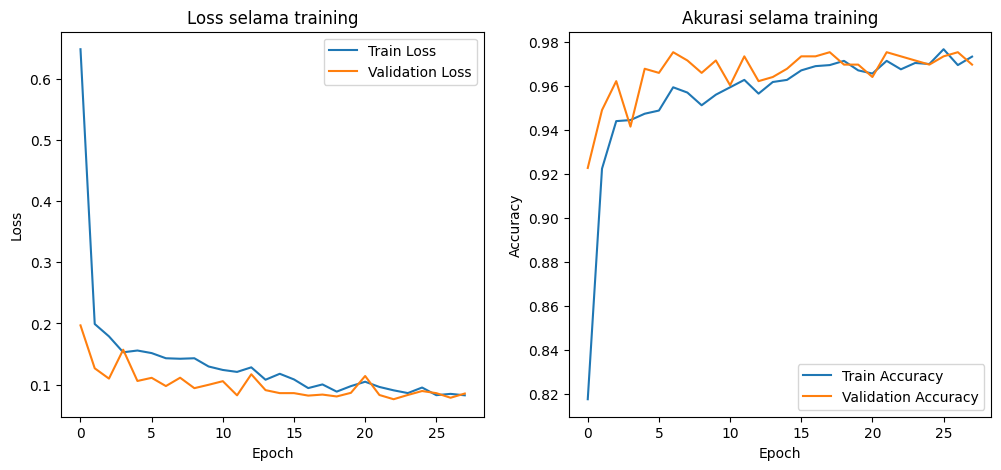

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss selama training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Akurasi selama training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
y_true = []
y_pred = []

for images, labels in val_set:
    preds = model.predict(images)
    preds_labels = preds.argmax(axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds_labels)

print(classification_report(y_true, y_pred))

f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1-score (macro): {f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       245
           1       0.96      1.00      0.98       286

    accuracy                           0.97       531
   macro avg       0.98      0.97      0.97       531
weighted avg       0.97      0.97      0.97       531

F1-score (ma

Found 231 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


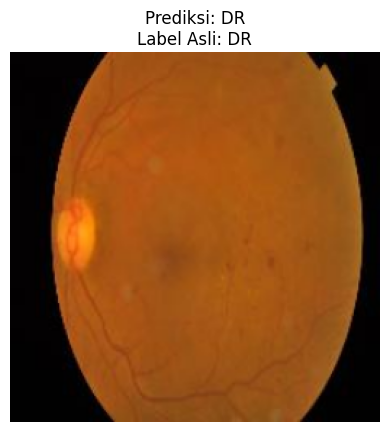

In [ ]:
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True
)

for images, labels in raw_test_ds.take(1):
    idx = random.randint(0, images.shape[0] - 1)

    raw_image = images[idx]
    label = labels[idx].numpy()

    input_image = tf.expand_dims(normalize_image(raw_image), axis=0)
    prediction = model.predict(input_image)
    pred_label = prediction.argmax(axis=1)[0]

    plt.imshow(raw_image.numpy().astype("uint8"))
    plt.axis('off')
    plt.title(f"Prediksi: {class_names[pred_label]}\nLabel Asli: {class_names[label]}")
    plt.show()
    break


In [ ]:
model.save("model_densenetRcnn.h5")
